#  Traditional Machine Learning Model
### RandomForest & XGBoost

### Project Objective
The goal of this project is to demonstrate the application of machine learning techniques in cybersecurity by detecting fraudulent credit card transactions. The solution covers the **full pipeline**, from data preprocessing to model training, evaluation, generalizability testing, and deployment-ready model saving.

### Project Scope
- **Problem Identification**: Fraudulent transactions are costly and increasingly sophisticated. Early detection using ML reduces financial losses and operational burden.
- **Data Sources**:
  - **Primary dataset**: 2013 credit card transactions with labeled fraud cases.
  - **Secondary dataset**: 2023 dataset for generalizability testing to ensure robustness.
- **Models**:
  - **Traditional ML**: RandomForest, XGBoost.
- **Evaluation Metrics**:
  - Precision, Recall, F1-score.
  - ROC-AUC, Confusion Matrix.
  - Threshold tuning to maintain desired precision (~0.80).

In [9]:
# ============================================
# Cell 1: Imports and environment setup
# ============================================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, confusion_matrix, auc
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import SMOTE
import joblib
import warnings
import kagglehub
warnings.filterwarnings('ignore')

### Helper Plotting & Evaluation Functions

Following cell defines reusable functions that help visualize and evaluate model performance.  
These functions are called throughout the notebook to provide consistent, clear metrics and charts.

#### **Functions Included:**
- Generating a labeled confusion matrix using Seaborn.  
- Plotting the Receiver Operating Characteristic (ROC) curve.  
- Printing precision, recall, F1-score, and support using.

The tools implemented ensure that all models in this project are evaluated consistently.

In [10]:
# ============================================
# Cell 2: Helper plotting functions
# ============================================
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def plot_roc(y_true, y_scores, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, label=f"AUC = {auc(fpr,tpr):.4f}")
    plt.plot([0,1],[0,1],'--', color='grey')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend()
    plt.show()

def classification_metrics(y_true, y_pred, y_scores=None):
    print(classification_report(y_true, y_pred, digits=4))
    if y_scores is not None:
        print("ROC-AUC:", roc_auc_score(y_true, y_scores))

### Kaggle Dataset
Downloading the primary dataset to be loaded into the model for training.

### [Dataset Link](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/data)


In [11]:
# ============================================
# Cell 3: Load dataset via KaggleHub
# ============================================
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Dataset downloaded to:", path)

df = pd.read_csv(os.path.join(path, "creditcard.csv"))
print(df.head())

Using Colab cache for faster access to the 'creditcardfraud' dataset.
Dataset downloaded to: /kaggle/input/creditcardfraud
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.

### Exploratory Data Analysis (EDA)
The cell performs a brief exploratory analysis on the credit card fraud dataset to understand its structure, class imbalance, and key feature behaviors.  
EDA is essential when it comes to fraud detection because fraudulent transactions are rare and often follow different statistical patterns than those found in legitimate ones.

#### **Steps Included:**

**1. Class Distribution Check**
- Prints the count of each class (`0 = legitimate`, `1 = fraud`).
- Visualizes the distribution using a bar plot.
- Confirms the extreme class imbalance (fraud cases are less than 0.2%).

**2. Transaction Amount Analysis**
- Plots a histogram of the Amount feature.
- Helps observe spending behavior and detect outliers or skewed distributions.

**3. Feature Engineering**
- Creates a new feature: Amount_log  
- Applies log1p transformation to reduce skew in the Amount variable.
- Helps models learn patterns more effectively.

**4. Dataset Preparation & Preprocessing**
- Creates df_model by dropping unnecessary columns such as Time, Amount, and Hour (if they are present).
- Cleaned dataset is used for model training in later steps.

The EDA stage ensures a strong understanding of the dataset before model training and helps guide preprocessing decisions.

Class
0    284315
1       492
Name: count, dtype: int64


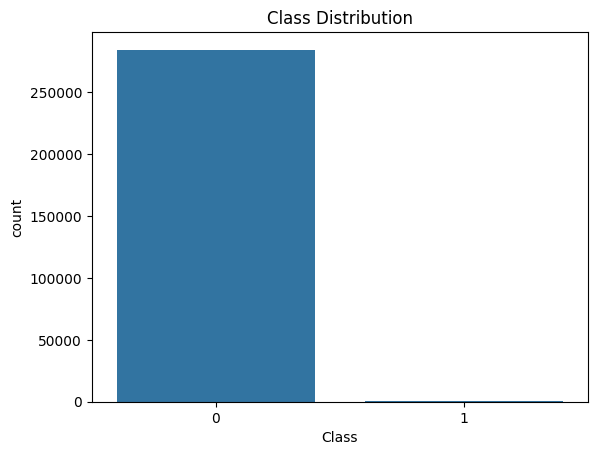

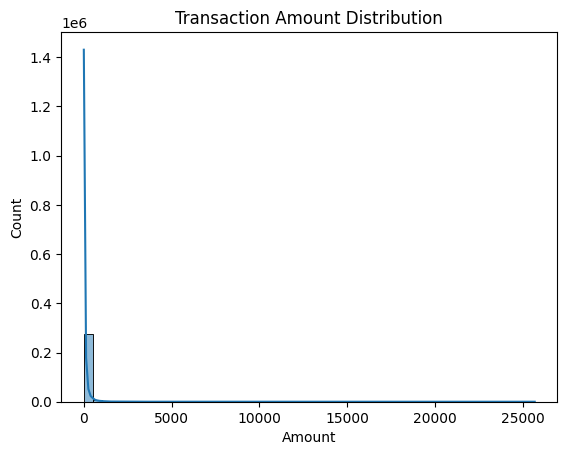

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_log
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.262539


In [12]:
# ============================================
# Cell 4: Quick EDA
# ============================================
print(df['Class'].value_counts())

sns.countplot(x='Class', data=df)
plt.title("Class Distribution")
plt.show()

sns.histplot(df['Amount'], bins=50, kde=True)
plt.title("Transaction Amount Distribution")
plt.show()


# Feature engineering (Updated: NO HOUR)
df['Amount_log'] = np.log1p(df['Amount'])

df_model = df.drop(['Time', 'Amount', 'Hour'], axis=1, errors='ignore')
df_model.head()

### Data Splitting, Scaling, and Class Imbalance Handling

The cell prepares the dataset for machine learning model training by performing three essential steps: feature scaling, train/test splitting, and oversampling to address class imbalance.

### **1. Feature/Label Separation**
- `X` contains all predictive features.
- `y` contains the target label (`0 = legitimate`, `1 = fraud`).

### **2. Feature Scaling with StandardScaler**
- Fraud datasets contain nonreadable features (V1–V28) with very different value ranges.
- Neural networks models and distance-based methods require standardized data.
- StandardScaler transforms features to have:
  - Mean = 0  
  - Standard deviation = 1  
- The fitted scaler is saved for the deployment app to apply identical preprocessing.

### **3. Train/Test Split**
- Dataset is split into **80% training** and **20% testing**.
- `stratify=y` ensures the fraud ratio stays consistent in both sets.
- `random_state=42` guarantees reproducibility.

### **4. Handling Severe Class Imbalance with SMOTE**
- Fraud cases represent far less than 1% of the dataset.
- **SMOTE (Synthetic Minority Oversampling Technique)** generates synthetic fraud samples to balance the training set.
- Oversampling only occurs on the training split to avoid data leakage.
- The output confirms the new class balance after SMOTE.


These steps ensure the model learns from a balanced dataset for resulting better fraud detection. Training on standardized inputs improves convergence. Avoids data leakage and maintains reliable evaluation metrics , which means it can be reliably deployed with consistent preprocessing


In [13]:
# ============================================
# Cell 5: Split and Scale
# ============================================
X = df_model.drop('Class', axis=1)
y = df_model['Class']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Save scaler for deployment
joblib.dump(scaler, "ml_scaler_creditcard.joblib")
print("Scaler saved as ml_scaler_creditcard.joblib")

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

# Handle imbalance through SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("After SMOTE:", np.bincount(y_train_sm))

Scaler saved as ml_scaler_creditcard.joblib
After SMOTE: [227451 227451]


### Model Training: Traditional Machine Learning Approaches

This cell trains **two machine learning models** to detect credit card fraud: **XGBoost** and **RandomForest**. Both are well-suited for the tabular, imbalanced credit card datasets provided in the model.

### **1. Target Precision**
- A desired precision value of 0.80 is set to ensures the model prioritizes **minimizing false positives**, which is highly important in fraud detection, due to the tendency in flagging legitimate transactions unnecessarily.

### **2. XGBoost Model**
- **Rationale**: XGBoost is a gradient boosting algorithm that excels at **capturing complex feature interactions**, important for detecting subtle fraud patterns. It often outperforms simpler tree-based models in predictive accuracy while being robust to overfitting when tuned properly.
- **Strengths**:
  - Strong performance on imbalanced data using `scale_pos_weight`.
  - Captures non-linear relationships in tabular datasets.
- **Considerations**:
  - Requires careful hyperparameter tuning.
  - False Negatives are capable of being produced if not processed correctly
- **Implementation Notes**:
  - Threshold tuning on the precision-recall curve ensures we meet business requirements for high precision.


### **3. RandomForest Model Training**
- **Rationale**: RandomForest is an ensemble of decision trees known for **robustness and interpretability**. It provides a baseline that is easy to implement and understand, and is less sensitive to hyperparameters than boosting methods.
- **Strengths**:
  - Handles imbalanced datasets well using `class_weight`.
  - Resistant to overfitting on small-to-medium tabular datasets.
- **Considerations**:
  - May not capture subtle fraud patterns as effectively as boosting methods.
   - Moderately longer training time compared to XGBoost (Around 5-6 minutes)
- **Implementation Notes**:
  - Precision-recall thresholding ensures high precision in identifying fraudulent transactions.

Both models produce **probability estimates**, allowing threshold tuning to meet **business-critical precision targets**. Using two complementary models allows for cross-validation of predictions and results, which provides confidence in deployment. Both fully trained models are optimal thresholds to determine high-precision fraud detection.




===== Training XGBoost =====
XGBoost optimal threshold: 0.006193348246191891
              precision    recall  f1-score   support

           0     0.9998    0.9996    0.9997     56864
           1     0.8037    0.8776    0.8390        98

    accuracy                         0.9994     56962
   macro avg     0.9018    0.9386    0.9194     56962
weighted avg     0.9995    0.9994    0.9994     56962

ROC-AUC: 0.9756204922880801


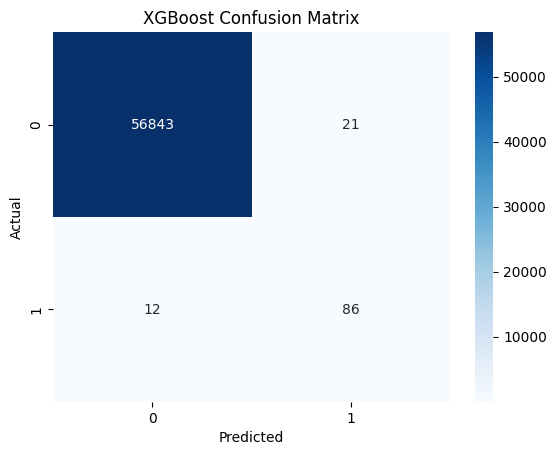

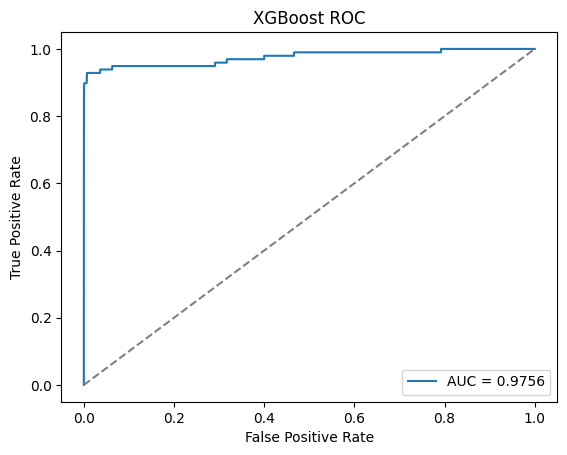

Saved: xgb_creditcard.pkl

===== Training RandomForest =====
RandomForest optimal threshold: 0.13
              precision    recall  f1-score   support

           0     0.9998    0.9996    0.9997     56864
           1     0.8037    0.8776    0.8390        98

    accuracy                         0.9994     56962
   macro avg     0.9018    0.9386    0.9194     56962
weighted avg     0.9995    0.9994    0.9994     56962

ROC-AUC: 0.9521584977547575


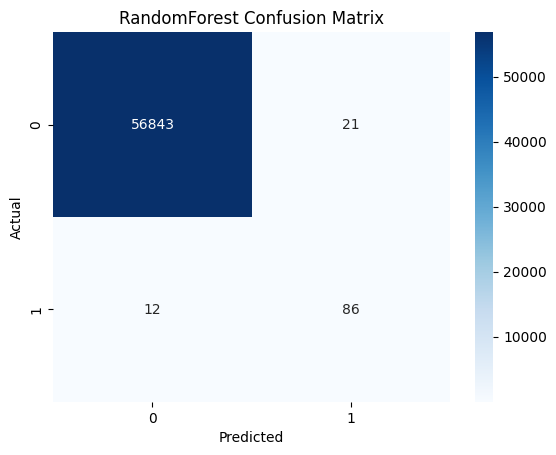

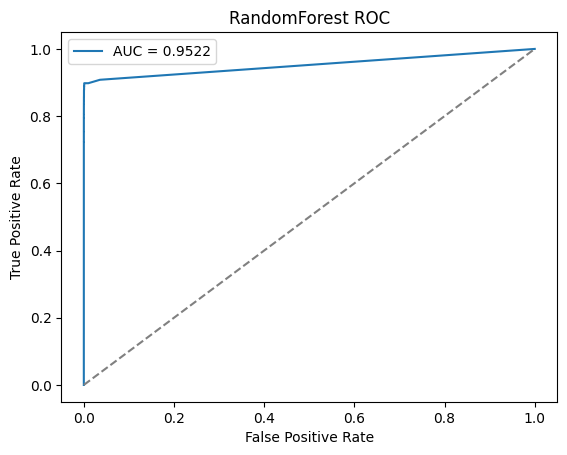

Saved: rf_creditcard.pkl

Training complete — models and scaler saved.


In [14]:
# ============================================
# Cell 6: Model Training (XGBoost + RF)
# ============================================
desired_precision = 0.80  # threshold target

# -------------------------
# Train XGBoost
# -------------------------
print("\n===== Training XGBoost =====")

xgb_model_raw = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='auc',
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),
    random_state=42
)

xgb_model_raw.fit(X_train, y_train)

# Probability calibration for better thresholds
xgb_model = CalibratedClassifierCV(xgb_model_raw, cv=3)
xgb_model.fit(X_train, y_train)

probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, probs_xgb)
idx = np.argmax(precision >= desired_precision)

# Fix: avoid index error
if idx == len(thresholds):
    optimal_threshold_xgb = 0.5
else:
    optimal_threshold_xgb = thresholds[idx]

print("XGBoost optimal threshold:", optimal_threshold_xgb)

y_pred_xgb = (probs_xgb >= optimal_threshold_xgb).astype(int)

classification_metrics(y_test, y_pred_xgb, probs_xgb)
plot_confusion_matrix(y_test, y_pred_xgb, "XGBoost Confusion Matrix")
plot_roc(y_test, probs_xgb, "XGBoost ROC")

# Save model
joblib.dump(xgb_model, "xgb_creditcard.pkl")
print("Saved: xgb_creditcard.pkl")



# -------------------------
# Train RandomForest
# -------------------------
print("\n===== Training RandomForest =====")

rf_model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced_subsample',
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
probs_rf = rf_model.predict_proba(X_test)[:,1]

precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, probs_rf)
idx_rf = np.argmax(precision_rf >= desired_precision)
optimal_threshold_rf = thresholds_rf[idx_rf]

print("RandomForest optimal threshold:", optimal_threshold_rf)

y_pred_rf = (probs_rf >= optimal_threshold_rf).astype(int)

classification_metrics(y_test, y_pred_rf, probs_rf)
plot_confusion_matrix(y_test, y_pred_rf, "RandomForest Confusion Matrix")
plot_roc(y_test, probs_rf, "RandomForest ROC")

# Save model
joblib.dump(rf_model, "rf_creditcard.pkl")
print("Saved: rf_creditcard.pkl")

print("\nTraining complete — models and scaler saved.")


### Preprocessing Single Transaction

Prepares a single transaction for model inference by converting a dictionary of features into a scaled array.

**Inputs**
- `row_dict`: Dictionary with features `V1..V28` and `Amount`.

**Processing**
1. Log-transform `Amount` → `Amount_log` to reduce skew.
2. Order features as `[V1..V28, Amount_log]`.
3. Convert to NumPy array and apply StandardScaler for normalization.

**Output**
- Scaled 2D array ready for ML model prediction (XGBoost, RandomForest, or MLP).


In [15]:
# ============================================
# Cell 7: Preprocess single transaction
# ============================================
def preprocess_transaction(row_dict):
    """
    row_dict: dict {V1..V28, Amount}
    → returns scaled vector for model inference
    """
    tmp = {}
    tmp['Amount_log'] = np.log1p(row_dict['Amount'])

    feat_order = [f'V{i}' for i in range(1, 29)] + ['Amount_log']

    arr = np.array([row_dict[f] for f in feat_order], dtype=float).reshape(1, -1)
    arr_scaled = scaler.transform(arr)
    return arr_scaled

### Generalizability Test with 2nd Dataset

Evaluates the trained model on a separate, unseen dataset to test generalizability.

### [Dataset Link](https://www.kaggle.com/datasets/nelgiriyewithana/credit-card-fraud-detection-dataset-2023/data)

**Purpose**
- Ensure that the model is not overfitted to the original dataset.
- Assess performance on a more recent or different dataset for **generalizability**.
- Validate that preprocessing, scaling, and thresholding are consistent.

**Steps**
1. **Download & Load Dataset**
   - Fetches the 2023 credit card fraud dataset via Kagglehub.
   - Loads the CSV into a DataFrame.

2. **Feature Engineering**
   - Log-transform `Amount` → `Amount_log`.
   - Drop unnecessary columns: id, original Amount, and Class.

3. **Preprocessing**
   - Apply the previously fitted StandardScaler to match training preprocessing.

4. **Prediction**
   - Use the trained XGBoost or RandomForest model.
   - Tune threshold for ~0.8 precision using Precision-Recall curve.
   - Generate predictions.

5. **Evaluation**
   - Display classification metrics, confusion matrix, and ROC curve for the 2023 dataset.

The intended desire for using scaled predictions and evaluation metrics on a secondary dataset to assess model's usuage on potential other real world examples.
- Updated `preprocess_transaction` function ensures new inputs are processed consistently.
- Provides quantitative analysis on how well the model performs on new, unseen data, unrelated to what was provided in training.


Using Colab cache for faster access to the 'credit-card-fraud-detection-dataset-2023' dataset.
Path to dataset files: /kaggle/input/credit-card-fraud-detection-dataset-2023
2023 dataset shape: (568630, 29)
Optimal threshold for ~0.8 precision: 0.00032388516796266216
              precision    recall  f1-score   support

           0     0.8899    0.7739    0.8279    284315
           1     0.8000    0.9043    0.8489    284315

    accuracy                         0.8391    568630
   macro avg     0.8450    0.8391    0.8384    568630
weighted avg     0.8450    0.8391    0.8384    568630

ROC-AUC: 0.9410511584374527


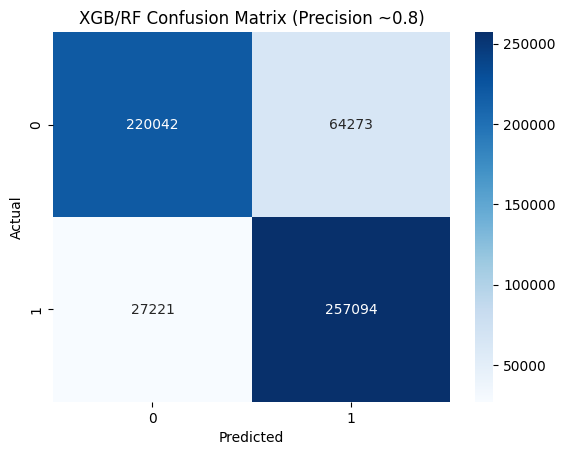

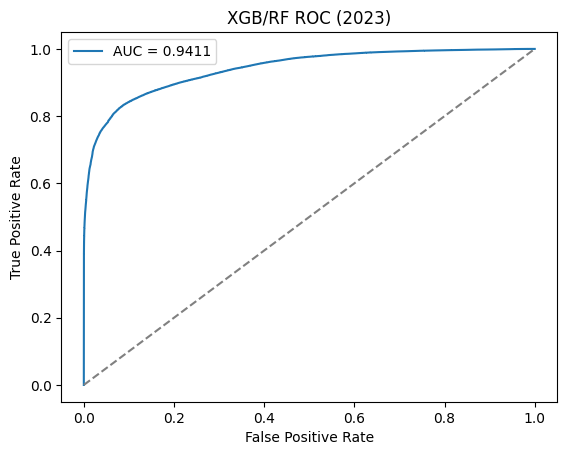

In [16]:
# =======================
# Cell 8: Generalizability test through 2nd dataset
# =======================
# Download latest version
path_2023 = kagglehub.dataset_download("nelgiriyewithana/credit-card-fraud-detection-dataset-2023")
print("Path to dataset files:", path_2023)

# Load CSV file
csv_files = [f for f in os.listdir(path_2023) if f.endswith('.csv')]
if len(csv_files) == 0:
    raise FileNotFoundError("No CSV file found in the 2023 dataset.")

csv_2023_path = os.path.join(path_2023, csv_files[0])
df_2023 = pd.read_csv(csv_2023_path)
df_2023.head()

# Feature engineering
df_2023['Amount_log'] = np.log1p(df_2023['Amount'])

# Drop id, original Amount, and Class
X_2023 = df_2023.drop(['id', 'Amount', 'Class'], axis=1)
y_2023 = df_2023['Class']

# Load trained scaler
scaler = joblib.load("ml_scaler_creditcard.joblib")
X_2023_scaled = scaler.transform(X_2023)
print("2023 dataset shape:", X_2023_scaled.shape)

# Evaluate XGBoost / RandomForest with tuned threshold
# Choose the model that exists
try:
    probs_2023 = xgb_model.predict_proba(X_2023_scaled)[:,1]
except:
    probs_2023 = rf_model.predict_proba(X_2023_scaled)[:,1]

# Tune threshold
desired_precision = 0.8
precision, recall, thresholds = precision_recall_curve(y_2023, probs_2023)
idx = np.argmax(precision >= desired_precision)
optimal_threshold = thresholds[idx]
print("Optimal threshold for ~0.8 precision:", optimal_threshold)

# Predict
y_pred_2023 = (probs_2023 >= optimal_threshold).astype(int)

classification_metrics(y_2023, y_pred_2023, probs_2023)
plot_confusion_matrix(y_2023, y_pred_2023, f"XGB/RF Confusion Matrix (Precision ~{desired_precision})")
plot_roc(y_2023, probs_2023, "XGB/RF ROC (2023)")


# Updated preprocess_transaction function
def preprocess_transaction(row_dict):
    """
    row_dict: dict with keys 'V1'...'V28', 'Amount'
    Returns scaled numpy array for model input
    """
    tmp = {}
    tmp['Amount_log'] = np.log1p(row_dict['Amount'])
    feat_order = [f'V{i}' for i in range(1,29)] + ['Amount_log']
    arr = np.array([row_dict[f] for f in feat_order], dtype=float).reshape(1,-1)
    arr_scaled = scaler.transform(arr)
    return arr_scaled
